<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/AWD_LSTM_small_patched_TPU_butch_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip install git+https://github.com/butchland/my_timesaver_utils > /dev/null

  Running command git clone -q https://github.com/butchland/my_timesaver_utils /tmp/pip-req-build-ffub3em8


In [4]:
!pip install git+https://github.com/butchland/fastai_xla_extensions > /dev/null

  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-pzkyxx4j


In [5]:
!pip install fastai2 > /dev/null

In [6]:
VERSION = "20200707" #@param ["1.5" ,"20200325", "20200515",  "20200707","nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version $VERSION > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  61626      0 --:--:-- --:--:-- --:--:-- 61626
Copying gs://tpu-pytorch/wheels/torch-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
| [1 files][123.8 MiB/123.8 MiB]                                                
Operation completed over 1 objects/123.8 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.                                      
ERROR:

In [7]:
!pip freeze | grep torch
!pip freeze | grep fastai2
!pip freeze | grep fastai_xla_extensions

torch==1.7.0a0+12b5bdc
torch-xla==1.6+5430aca
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.0a0+86b6c3e
fastai2==0.0.25


In [8]:
import fastai_xla_extensions.core

In [9]:
from fastai2.text.all import *

In [10]:
from my_timesaver_utils.profiling_callback import *

In [11]:
default_device()

device(type='xla', index=1)

In [12]:
path = untar_data(URLs.IMDB_SAMPLE)

In [13]:
#hide
Path.BASE_PATH = path

In [14]:
path.ls()

(#1) [Path('texts.csv')]

In [15]:
df = pd.read_csv(path/'texts.csv')

In [16]:
dls = TextDataLoaders.from_df(df,path=path, text_col='text', label_col='label', valid_col='is_valid')

In [17]:
dls.device

device(type='xla', index=1)

In [18]:
learner = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [19]:
learner.to_my_profile(); learner.my_profile.clear_stats()

In [22]:
# learner.summary()

In [20]:
learner.xla_opt

XLAOptCallback

In [21]:
learner.fit(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.869449,0.684792,0.565000,31:57
1,0.869813,0.676956,0.570000,26:17


In [22]:
learner.my_profile.print_stats()

fit  called 1 times. max: 3495.276 avg: 3495.276
   epoch  called 2 times. max: 1917.664 avg: 1747.636
      train  called 2 times. max: 1540.809 avg: 1419.630
         train_batch  called 24 times. max: 939.952 avg: 118.244
            train_pred  called 24 times. max: 574.763 avg: 46.992
            train_loss  called 24 times. max: 0.020 avg: 0.003
            train_backward  called 24 times. max: 0.005 avg: 0.002
            train_step  called 24 times. max: 364.126 avg: 70.942
            train_zero_grad  called 24 times. max: 1.130 avg: 0.305
      valid  called 2 times. max: 376.840 avg: 327.991
         valid_batch  called 8 times. max: 277.435 avg: 81.844
            valid_pred  called 8 times. max: 1.452 avg: 0.447
            valid_loss  called 8 times. max: 0.081 avg: 0.028


In [23]:
train_pred_stats = learner.my_profile.get_stats('train_pred')
train_step_stats = learner.my_profile.get_stats('train_step')
train_batch_stats = learner.my_profile.get_stats('train_batch')
valid_batch_stats = learner.my_profile.get_stats('valid_batch')
train_stats = learner.my_profile.get_stats('train')
valid_stats = learner.my_profile.get_stats('valid')
epoch_stats = learner.my_profile.get_stats('epoch')
fit_stats = learner.my_profile.get_stats('fit')

In [24]:
%matplotlib inline

In [25]:
def show_stats(data,title):
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    plt.xlabel('batches', fontsize=18)
    plt.ylabel('secs', fontsize=16)
    plt.plot(data,);

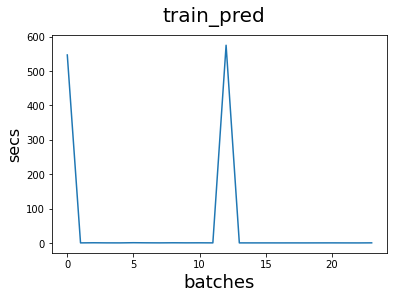

In [26]:
show_stats(train_pred_stats[2],'train_pred')

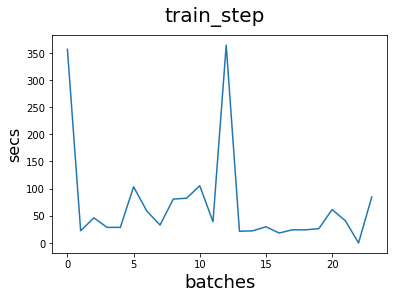

In [27]:
show_stats(train_step_stats[2],'train_step')

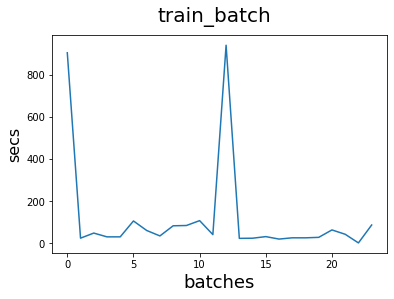

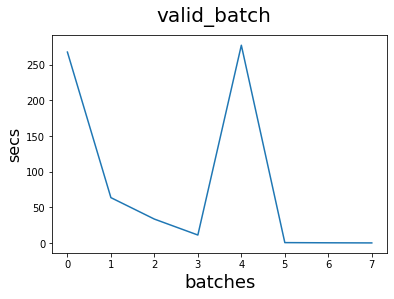

In [28]:
show_stats(train_batch_stats[2],'train_batch')
show_stats(valid_batch_stats[2],'valid_batch')

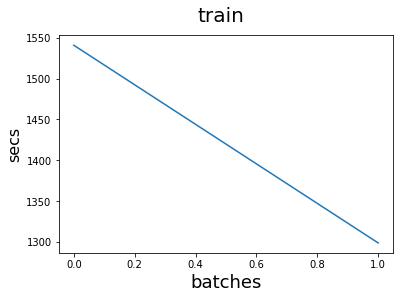

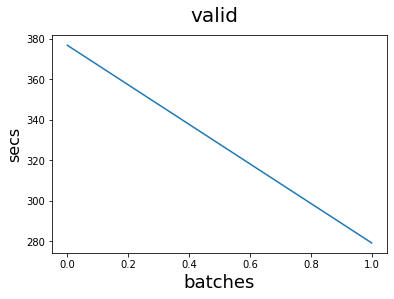

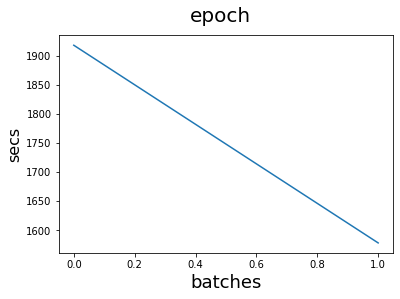

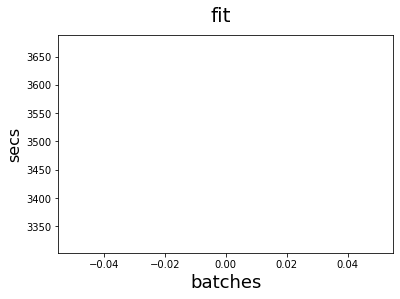

In [29]:
show_stats(train_stats[2],'train')
show_stats(valid_stats[2],'valid')
show_stats(epoch_stats[2],'epoch')
show_stats(fit_stats[2],'fit')

In [31]:
xla_model = learner.model.to(default_device());one_param(xla_model)[0].device

device(type='xla', index=1)

In [33]:

xb, yb = dls.one_batch(); xb[0].device

device(type='xla', index=1)

In [34]:
import torch

In [37]:
%%time
with torch.no_grad(): pred = xla_model(xb)


CPU times: user 3.41 s, sys: 1.14 s, total: 4.55 s
Wall time: 2min 41s


In [38]:
%%time
pred2 = xla_model(xb)

CPU times: user 5.13 s, sys: 2.26 s, total: 7.39 s
Wall time: 5min 2s


In [39]:
xla_model.reset()

Resetting the model speeds up the forward step to around the same speed as forward with no autograd.

In [40]:
%%time
pred3 = xla_model(xb)

CPU times: user 3.13 s, sys: 993 ms, total: 4.12 s
Wall time: 2min 29s
